In [1]:
# === Shared setup (run once at top) ===
from pathlib import Path
import pandas as pd, numpy as np, cv2, os, random, time

ROOT    = Path(r"C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection")
RAW_DIR = ROOT / "data" / "raw_images"          # has 0..9 subfolders
WORK    = ROOT / "workspace"
CROPS_DIR = WORK / "crops_128"                   # normalized crops saved here
SPLITS  = WORK / "splits"
MODELS  = ROOT / "models"
IMG_SIZE = (128,128)                             # (W,H)
RNG_SEED = 42

for d in [WORK, CROPS_DIR, SPLITS, MODELS]: d.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)


ROOT: C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection


In [2]:
import os, cv2, json, shutil, numpy as np, pandas as pd
from pathlib import Path

In [17]:
# ---  Stratified train/val/test split ---
import pandas as pd
from sklearn.model_selection import train_test_split

def list_crops(root: Path):
    rows = []
    for cls_dir in sorted(root.glob("*")):
        if not cls_dir.is_dir(): continue
        cls = int(cls_dir.name)
        for p in cls_dir.glob("*"):
            rows.append(dict(path=str(p), cls=cls))
    return pd.DataFrame(rows)

clean_df = list_crops(KEEP_DIR)
print("Clean set:", len(clean_df), "Per-class:", clean_df.groupby("cls").size().to_dict())

train_df, rest_df = train_test_split(clean_df, test_size=0.20, random_state=RNG_SEED, stratify=clean_df["cls"])
val_df, test_df = train_test_split(rest_df, test_size=0.50, random_state=RNG_SEED, stratify=rest_df["cls"])

SPLITS.mkdir(parents=True, exist_ok=True)
train_df.to_csv(SPLITS/"train.csv", index=False)
val_df.to_csv(SPLITS/"val.csv", index=False)
test_df.to_csv(SPLITS/"test.csv", index=False)

print("Saved:", SPLITS)
print("Counts:", len(train_df), len(val_df), len(test_df))


Clean set: 1716 Per-class: {0: 152, 1: 154, 2: 132, 3: 198, 4: 181, 5: 207, 6: 158, 7: 158, 8: 173, 9: 203}
Saved: C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\workspace\splits
Counts: 1372 172 172


In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# SPLITS is already defined in your setup: WORK / "splits"
train = pd.read_csv(SPLITS / "train.csv")
val   = pd.read_csv(SPLITS / "val.csv")
test  = pd.read_csv(SPLITS / "test.csv")

# keep a column telling which split each row belongs to
train["split"] = "train"
val["split"]   = "val"
test["split"]  = "test"

splits_df = pd.concat([train, val, test], ignore_index=True)
splits_df["cls"] = splits_df["cls"].astype(int)
classes = sorted(splits_df["cls"].unique())


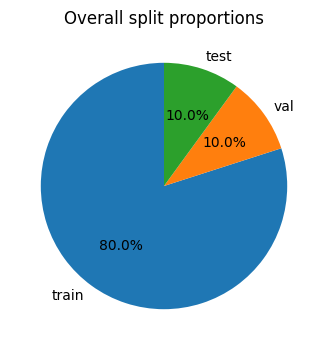

In [20]:
plt.figure(figsize=(5,4))
sizes = [len(train), len(val), len(test)]
plt.pie(sizes, labels=["train","val","test"], autopct="%1.1f%%", startangle=90)
plt.title("Overall split proportions")
plt.show()


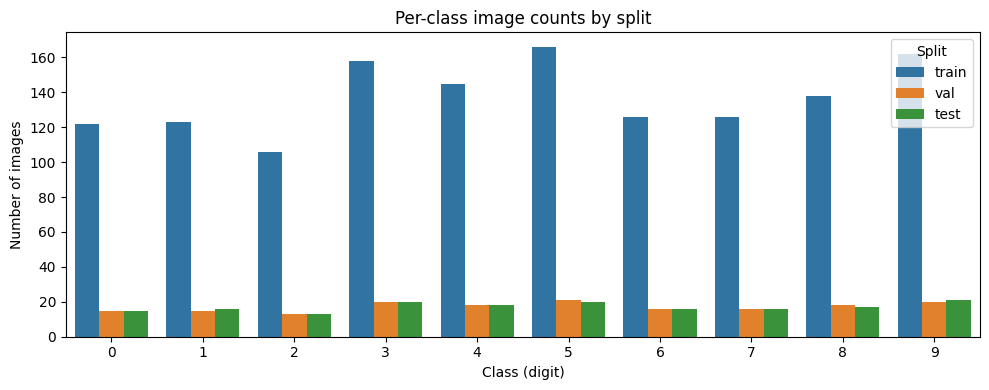

In [21]:
plt.figure(figsize=(10,4))
sns.countplot(data=splits_df, x="cls", hue="split", order=classes)
plt.title("Per-class image counts by split")
plt.xlabel("Class (digit)")
plt.ylabel("Number of images")
plt.legend(title="Split")
plt.tight_layout()
plt.show()


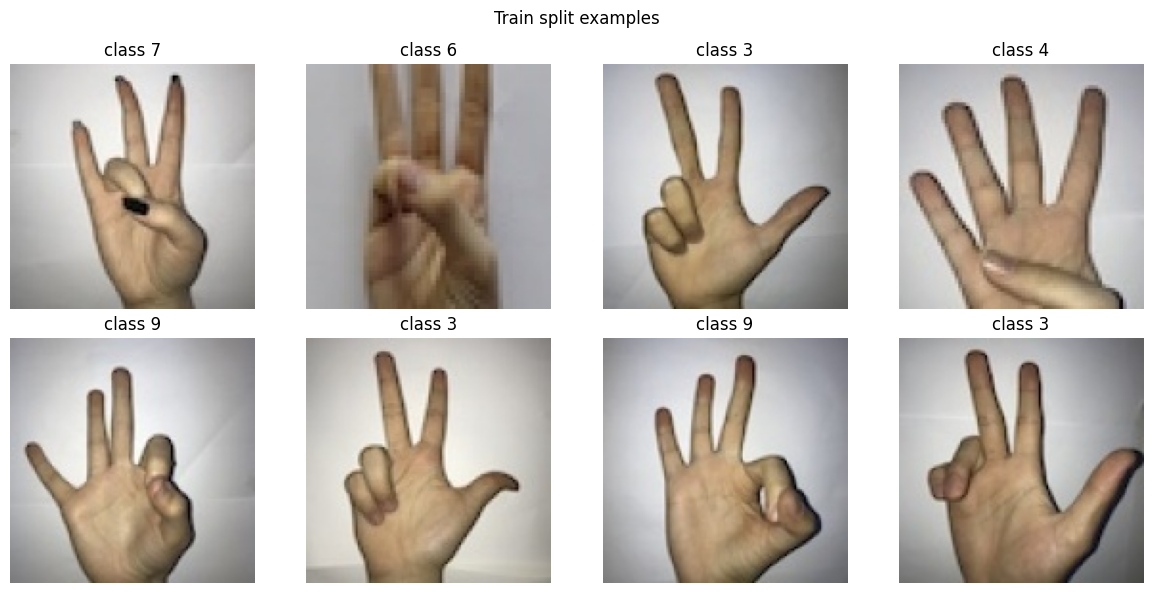

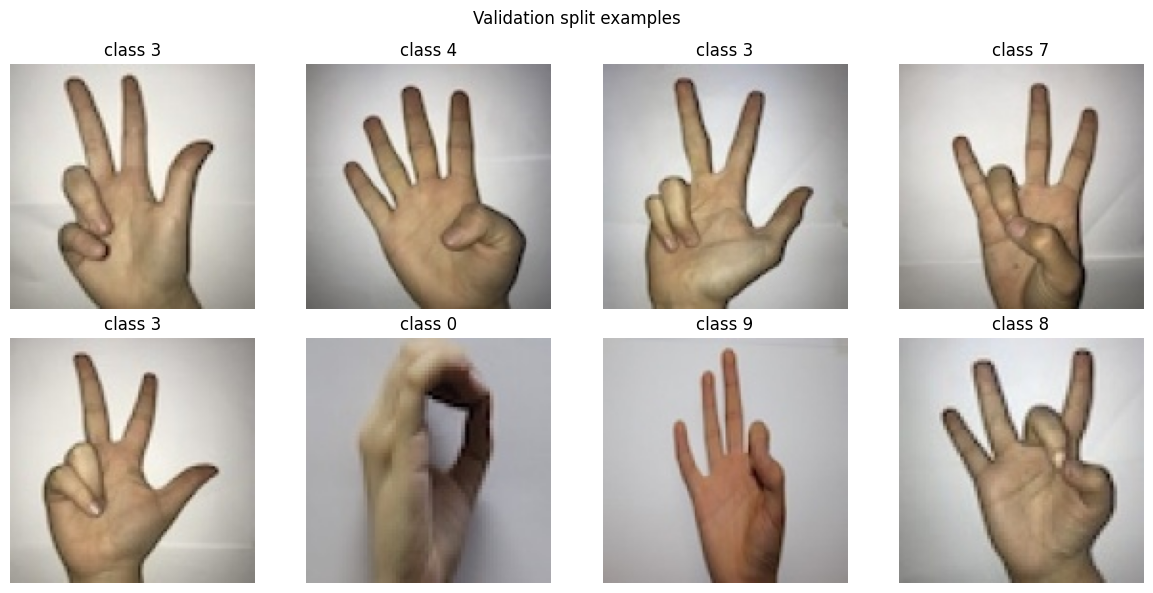

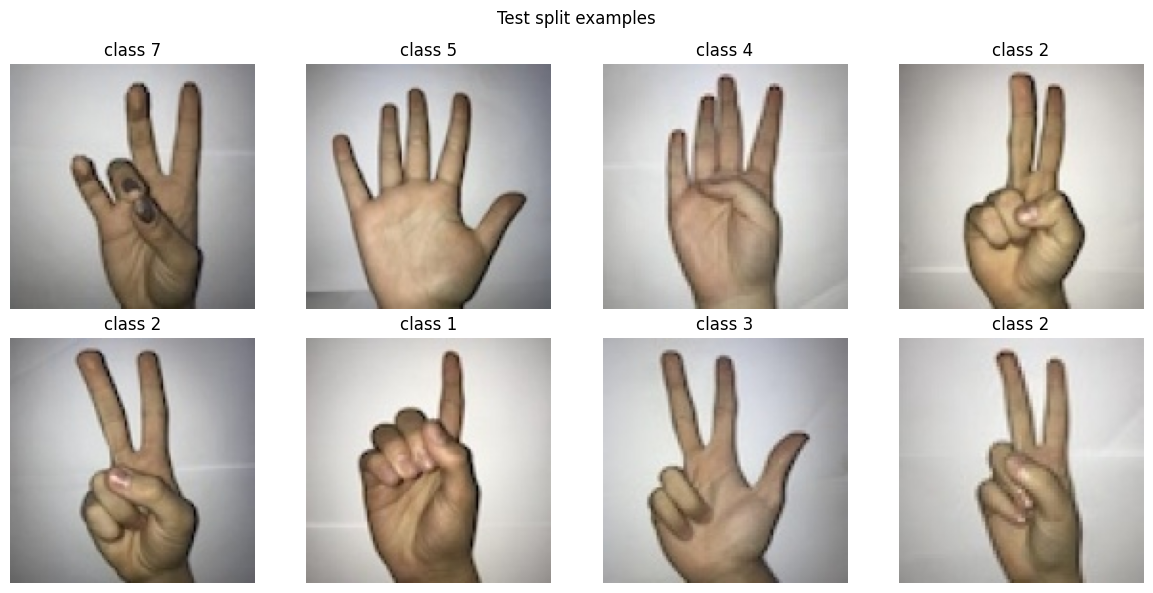

In [25]:
import cv2
from pathlib import Path

def show_examples(df, title, n=8):
    """Show n random images with class labels."""
    sample = df.sample(min(n, len(df)), random_state=42)
    cols = 4
    rows = int((len(sample) + cols - 1) // cols)
    plt.figure(figsize=(cols*3, rows*3))
    for i, (_, r) in enumerate(sample.iterrows(), 1):
        bgr = cv2.imread(r["path"])
        if bgr is None: 
            continue
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i)
        plt.imshow(rgb)
        plt.title(f"class {int(r['cls'])}")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_examples(train, "Train split examples")
show_examples(val,   "Validation split examples")
show_examples(test,  "Test split examples")
